# 01 - Modelo físico de un motor rotatorio

Este notebook muestra:
- El modelo matemático simplificado de un motor rotatorio con inercia, fricción viscosa y fricción Coulomb.
- Cómo simular la dinámica con diferentes parámetros.
- Cómo visualizar la posición y velocidad angular.


## Principio físico

Partimos de la **ley de balance de torques** para un sistema rotatorio:

$
I \cdot \frac{d\omega}{dt} = T_{drive} - b \cdot \omega - T_{coulomb} - T_{load}
$

**Donde:**
- $ I $: momento de inercia [kg·m²]
- $ \omega $: velocidad angular [rad/s]
- $ T_{drive} $: torque generado por el motor (proporcional a la corriente o throttle)
- $ b $: coeficiente de fricción viscosa [Nm·s/rad]
- $ T_{coulomb} $: torque de fricción seca [Nm]
- $ T_{load} $: torque de carga externa (opcional)

Esta ecuación se integra en pasos discretos para simular la evolución de velocidad y posición.


In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("src")

## Simulación de motor con carga real

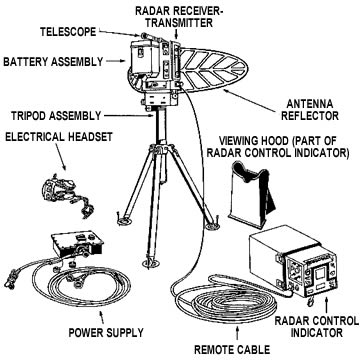!

**Inercia total**:
    
El parámetro `inertia` en `RotaryMotor` debe representar la **inercia de TODO el sistema rotatorio**:

* Motor (rotor)
* Antena (estructura rotante)
* Eje, base giratoria, etc.

**Carga externa (torque)**:

`external_torque` simula una fuerza que se opone o ayuda:

* Viento, fricción de rodamientos, peso desbalanceado.
* En este caso, puede ser un torque *constante* si hay inclinación, o simplemente fricción adicional, pero se considera despreciable.

** Fricción viscosa y Coulomb**:

Siempre hay:

* `friction_viscous`: depende de rodamientos, engranajes, cojinetes.
* `friction_coulomb`: par seco que se opone siempre al movimiento, sin depender de la velocidad.

**Ejemplo de cálculo simplificado**

Para estimar la **inercia de la antena**:

Fórmula básica para un cilindro o disco:

$$
I = \frac{1}{2} m r^2
$$

Supongamos:

* Antena + base giratoria ≈ 60 kg.
* Radio efectivo ≈ 0.5 m.

Entonces:

$$
I_{antena} = \frac{1}{2} \cdot 60 \cdot (0.5)^2 = 7.5 ~[kg~m^2]
$$

Si el motor tiene rotor pequeño, es despreciable comparado con la antena.

✔️ **Valor de inercia razonable para este caso:**

```python
inertia = 7.5  # kg·m² (orden de magnitud)
```

**¿Torque externo?**

Si tu antena está bien balanceada, `external_torque` puede ser ≈ 0.
Pero si hay un ligero desbalanceo, podés modelar un `external_torque` constante para simular la tendencia a irse para un lado:

```python
external_torque = 0.1  # Nm (depende de la inclinación o viento)
```

**Fricción viscosa y Coulomb**

Valores típicos para un sistema mecánico de esta escala:

```python
friction_viscous = 0.05  # Nm·s/rad
friction_coulomb = 0.2   # Nm
```

Se ajustan por prueba y error para que la simulación coincida con la desaceleración real.

**Concepto clave**

* La **inercia grande** limita la aceleración máxima → necesitás más torque para girar rápido.
* La **fricción viscosa y Coulomb** determinan cómo se frena cuando cortás corriente.
* El **torque externo** genera tendencia a moverse o quedarse trabado.


### Tabla de especificación orientativa

| **Parámetro**                     | **Valor aproximado**            | **Notas prácticas**                                                                     |
| --------------------------------- | ------------------------------- | --------------------------------------------------------------------------------------- |
| **Masa rotatoria (carga)**        | 15–20 kg                        | Parte móvil de la antena y soporte mecánico.                                            |
| **Radio efectivo**                | 0.3–0.5 m                       | Depende del diseño físico de la base giratoria y forma de la antena.                    |
| **Inercia total (reflejada)**     | 1.0–2.5 kg·m²                   | Calculada como disco: *I* ≈ ½·m·r².                                                     |
| **Torque carga (acel.)**          | 3–6 Nm                          | Para acelerar de 0 a \~3 rad/s en 1 s (muy suave, para PAN lento).                      |
| **Torque nominal motor (salida)** | 8–12 Nm                         | Incluye reserva para fricción, viento, inclinación.                                     |
| **Relación de reducción**         | 15:1 a 30:1                     | Reductora planetaria típica; motor gira rápido y reduce al eje de salida lento.         |
| **Velocidad eje salida**          | 5–30 rpm                        | PAN lento para vigilancia terrestre.                                                    |
| **Velocidad motor**               | 3000–4000 rpm                   | Según relación de transmisión.                                                          |
| **Potencia nominal motor**        | 100–200 W                       | Para cubrir torque nominal a velocidad deseada con algo de margen.                      |
| **Corriente nominal**             | 4–10 A                          | A 24 V; depende de eficiencia de motor y caja reductora.                                |
| **Corriente pico**                | 15–25 A                         | Para arranques breves o cambios de dirección rápidos. Roboclaw 30A cubre esto.          |
| **Encoder**                       | Absoluto 12–14 bits (SSI/BiSS)  | Resolución de ±0.1–0.2°. Opcional: incremental si la referencia absoluta no es crítica. |
| **Fuente de alimentación**        | 24–36 V DC, 10–15 A mínimo      | Para cubrir corriente nominal + margen de picos.                                        |
| **Rigidez mecánica**              | Sin juego excesivo (*backlash*) | La caja reductora debe tener backlash bajo para evitar oscilaciones en el lazo PID.     |


In [2]:
from motorcontrol.rotary_motor import RotaryMotor, simulate_motor, trapezoidal_profile, MotorLogger, plot_motor_log

# Instancia motor
motor = RotaryMotor(
    inertia=2.5,           # kg·m²
    friction_viscous=0.1,  # Nm·s/rad
    max_torque=12.0,       # Nm
    friction_coulomb=0.3,  # Nm
    external_torque=0.0    # Nm
)

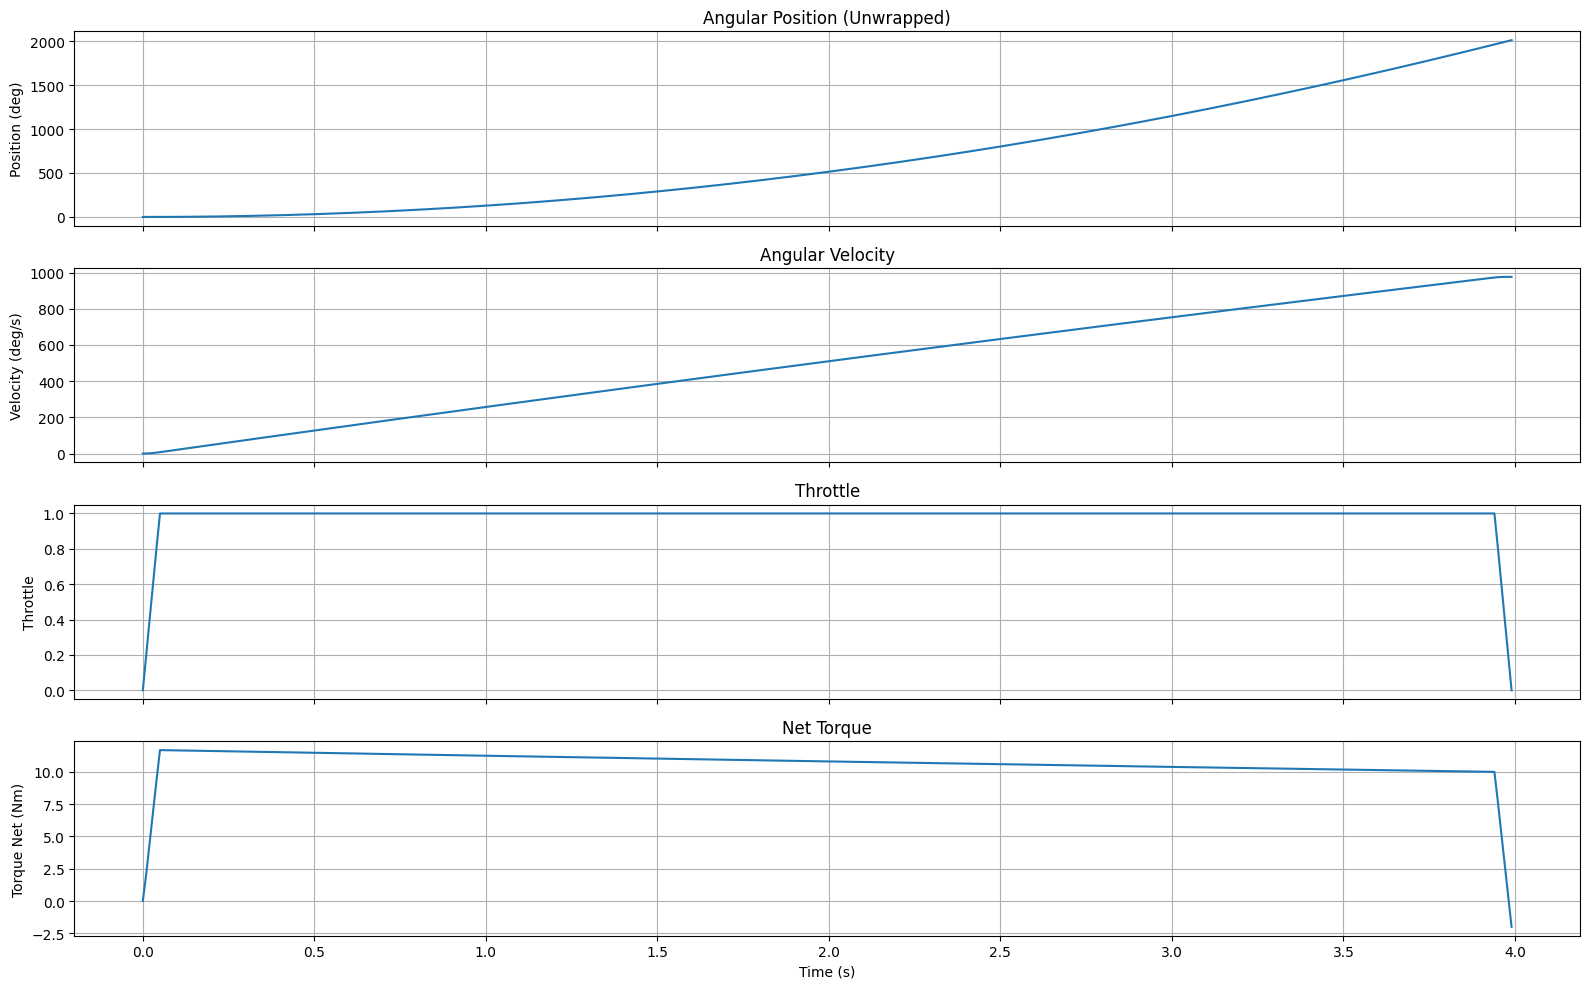

In [3]:
# Simulá
throttle_signal= trapezoidal_profile()
logger = simulate_motor(motor, throttle_signal, dt=0.01, verbose=False)

# Graficá todo junto
plot_motor_log(logger)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact

def run_and_animate(throttle_val, mass_kg):
    r_eff = 0.4
    inertia = 0.5 * mass_kg * r_eff**2

    motor = RotaryMotor(
        inertia=inertia,
        friction_viscous=0.05,
        max_torque=10.0,
        friction_coulomb=0.2,
        external_torque=0.0
    )

    dt = 0.01
    t_max = 5.0
    steps = int(t_max / dt)
    logger = MotorLogger()

    for step in range(steps):
        t = step * dt
        motor.set_throttle(throttle_val)
        motor.update(dt)
        logger.log(t, motor)

    data = logger.as_dict()
    positions = np.radians(data["position"])

    fig, ax = plt.subplots(subplot_kw={'polar': True})
    arrow, = ax.plot([], [], lw=3)
    ax.set_ylim(0, 1)

    def init():
        return arrow,

    def update(frame):
        angle = positions[frame] % (2 * np.pi)
        arrow.set_data([angle, angle], [0, 1])
        return arrow,

    ani = FuncAnimation(fig, update, frames=len(positions),
                        init_func=init, blit=True, interval=50)

    plt.close(fig)
    return HTML(ani.to_html5_video())

interact(
    run_and_animate,
    throttle_val=widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05),
    mass_kg=widgets.FloatSlider(value=30.0, min=10.0, max=60.0, step=1.0)
);

interactive(children=(FloatSlider(value=0.5, description='throttle_val', max=1.0, step=0.05), FloatSlider(valu…